In [10]:
import pickle
import numpy as np

import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator

In [11]:
point_cloud_location = "/home/chris/Code/PointClouds/data/ply/CircularVentilationGrateExtraCleanedFull.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

# Preprocess the point cloud
pcd = util.preProcessCloud(pcd)
pcd_points = np.asarray(pcd.points)

In [12]:
with open("bend_visualization_data.pkl", "rb") as f:
    data = pickle.load(f)

intersection_line = data["intersection_line"]
bend_edges = data["bend_edges"]
cluster_points = data["cluster_points"]
cluster_derivatives = data["cluster_derivatives"]
all_normals = data["all_normals"]
segment_indices = data["segment_indices"]

print(f'length of intersection line: {len(intersection_line)}')
print(f'length of bend edges: {len(bend_edges)}')
print(f'length of cluster points: {len(cluster_points)}')
print(f'length of cluster derivatives: {len(cluster_derivatives)}')
print(f'length of all normals: {len(all_normals)}')
print(f'length of segments: {len(segment_indices)}')
print(f'segment indices[0]: {segment_indices[0]}')

length of intersection line: 2
length of bend edges: 2
length of cluster points: 10422
length of cluster derivatives: 10422
length of all normals: 2114266
length of segments: 7
segment indices[0]: [      0       1       2 ... 2114263 2114264 2114265]


In [13]:
class ArcLengthCalculator:
    def __init__(self, pcd, intersection_line, bend_edges, bend_cluster_points, cluster_derivatives, all_normals, segment_indices, intersection_step_size=0.5, derivative_step_size=0.2, radius=2):
        self.pcd = pcd
        self.points = np.asarray(pcd.points)

        if len(pcd.points) != len(all_normals):
            raise ValueError(f"Mismatch: {len(pcd.points)} points in PCD, but {len(all_normals)} normals loaded. "
                     "Make sure the point cloud is preprocessed the same way.")
        else:
            print(f"Loaded {len(all_normals)} normals for {len(pcd.points)} points in PCD. Proceeding.")
        self.intersection_line = intersection_line
        self.bend_cluster_points = bend_cluster_points
        self.bend_cluster_derivatives = cluster_derivatives
        self.bend_cluster_kdtree = cKDTree(self.bend_cluster_points)
        self.pcd_kdtree = cKDTree(self.points)
        self.start_point, self.end_point = map(np.array, bend_edges)
        self.intersection_step_size = intersection_step_size
        self.derivative_step_size = derivative_step_size
        self.all_normals = all_normals
        self.segment_indices = segment_indices
        self.radius = radius
        self.intersection_it = 0
        self.derivative_it = 0

        self.pcd.paint_uniform_color([0.6, 0.6, 0.6])
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window("ArcLengthCalculator")
        self.vis.add_geometry(self.pcd)

        self.vis.register_key_callback(262, self.step_along_intersection)
        self.vis.register_key_callback(265, self.step_across_derivative)
        self.vis.register_key_callback(264, self.backstep_across_derivative)

        self.plane_dominant_bins = {}
        for plane_id in [0, 1]:
            self.plane_dominant_bins[plane_id] = self.get_dominant_bin_ranges(
                self.all_normals[self.segment_indices[plane_id]],
                threshold=0.2,
                bin_size=1
            )

        self.step_along_intersection(self.vis)

    def plot_histogram_with_dominant_bins(self, angles, bin_edges, dominant_ranges, title, color):
        import matplotlib.pyplot as plt
        counts, edges, bars = plt.hist(angles, bins=bin_edges, color=color, edgecolor='black')
        for i, bar in enumerate(bars):
            bin_start = edges[i]
            bin_end = edges[i+1]
            for dom_start, dom_end in dominant_ranges:
                if np.isclose(bin_start, dom_start, atol=1e-6) and np.isclose(bin_end, dom_end, atol=1e-6):
                    bar.set_color('green')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def get_dominant_bin_ranges(self, normals, threshold=0.2, bin_size=1):
        dominant_bins = {}

        azimuth = np.degrees(np.arctan2(normals[:, 1], normals[:, 0]))
        az_hist, az_edges = np.histogram(azimuth, bins=np.arange(-180, 181, bin_size))
        az_ranges = []
        for i in range(len(az_hist)):
            if az_hist[i] / len(azimuth) > threshold:
                for offset in [-2, 0, 2]:
                    idx = i + offset
                    if 0 <= idx < len(az_hist):
                        az_ranges.append((az_edges[idx], az_edges[idx + 1]))

        zenith = np.degrees(np.arccos(np.clip(normals[:, 2], -1, 1)))
        zen_hist, zen_edges = np.histogram(zenith, bins=np.arange(0, 181, bin_size))
        zen_ranges = []
        for i in range(len(zen_hist)):
            if zen_hist[i] / len(zenith) > threshold:
                for offset in [-1, 0, 1]:
                    idx = i + offset
                    if 0 <= idx < len(zen_hist):
                        zen_ranges.append((zen_edges[idx], zen_edges[idx + 1]))
                        
        dominant_bins["azimuth"] = az_ranges
        dominant_bins["zenith"] = zen_ranges
        self.plot_histogram_with_dominant_bins(azimuth, az_edges, az_ranges, "Azimuth Histogram", color='skyblue')
        self.plot_histogram_with_dominant_bins(zenith, zen_edges, zen_ranges, "Zenith Histogram", color='salmon')

        return dominant_bins

    def is_normal_in_any_bin(self, normal, bin_ranges, mode):
        if mode == "azimuth":
            angle = np.degrees(np.arctan2(normal[1], normal[0]))
        elif mode == "zenith":
            angle = np.degrees(np.arccos(np.clip(normal[2], -1, 1)))
        else:
            raise ValueError("Invalid mode: choose 'azimuth' or 'zenith'")

        for start, end in bin_ranges:
            if start <= angle < end:
                return True
        return False
    
    def check_plane_alignment(self, normal):
        """Returns a dict indicating whether the normal aligns with plane 0 or 1."""
        result = {}

        for plane_id in [0, 1]:
            bins = self.plane_dominant_bins[plane_id]
            az_bins = bins.get("azimuth", [])
            zen_bins = bins.get("zenith", [])

            az_match = self.is_normal_in_any_bin(normal, az_bins, "azimuth") if az_bins else True
            zen_match = self.is_normal_in_any_bin(normal, zen_bins, "zenith") if zen_bins else True

            # Require both if both bins are present, otherwise just match the available one
            result[plane_id] = az_match and zen_match

        return result
    
    def align_normals(self, reference_normal, neighbor_directions):
        aligned_normals = np.array(neighbor_directions)
        
        # Check dot product: If negative, flip the normal
        for i in range(len(aligned_normals)):
            if np.dot(reference_normal, aligned_normals[i]) < 0:
                aligned_normals[i] = -aligned_normals[i]

        return aligned_normals
    
    def step_along_intersection(self, vis):
        self.derivative_it = 0
        colors = np.asarray(self.pcd.colors)
        #colors[:] = [0.6, 0.6, 0.6]  # Reset
        self.pcd.colors = o3d.utility.Vector3dVector(colors)
        if hasattr(self, 'line_set'):
            self.vis.remove_geometry(self.line_set)
        
        direction_vector = self.intersection_line[0] / np.linalg.norm(self.intersection_line[0])
        to_end = self.end_point - self.start_point
        if np.dot(direction_vector, to_end) < 0:
            direction_vector *= -1  # Flip if it's pointing toward the wrong side
        
        self.direction_vector = direction_vector
        sampled_point = self.start_point + (self.intersection_it*self.intersection_step_size)*self.direction_vector
        if np.linalg.norm(sampled_point - self.start_point) > np.linalg.norm(self.end_point - self.start_point):
            return
        
        idx = self.bend_cluster_kdtree.query(sampled_point)[1]
        base = self.bend_cluster_points[idx]
        self.base_point = base
        self.last_bend_point = base
        neighbor_indices = self.bend_cluster_kdtree.query_ball_point(base, self.radius)
        neighbor_derivatives = self.bend_cluster_derivatives[neighbor_indices]
        aligned_neighbor_derivatives = self.align_normals(neighbor_derivatives[0], neighbor_derivatives)
        self.current_derivative = np.mean(aligned_neighbor_derivatives, axis=0)
        self.current_derivative /= np.linalg.norm(self.current_derivative)
        end = base + self.current_derivative * 2
        base = base - self.current_derivative * 2

        self.line_set = self.create_arrow_line(base, end, color=[1, 0, 0])

        self.vis.add_geometry(self.line_set)

        view_ctl = self.vis.get_view_control()
        lookat = sampled_point
        zoom = 0.080000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera
        self.intersection_it += 1

    def highlight_plane_bin(self, normals, bin_edges, bin_index, angle_type):
        if angle_type == "azimuth":
            angles = np.arctan2(normals[:,1], normals[:,0])
            angles = (angles + 2 * np.pi) % (2 * np.pi)
        else:  # zenith
            angles = np.arccos(normals[:,2])

        in_bin = (angles >= bin_edges[bin_index]) & (angles < bin_edges[bin_index+1])
        return in_bin
    
    def step_across_derivative(self, vis):
        self.derivative_it += 1
        self.last_bend_point = self.last_bend_point + self.derivative_step_size*self.current_derivative
        idx = self.pcd_kdtree.query(self.last_bend_point)[1]
        point = self.points[idx]
        neighbor_indices = self.bend_cluster_kdtree.query_ball_point(point, self.radius)
        if len(neighbor_indices) > 5:
            self.vis.remove_geometry(self.line_set)
            neighbor_derivatives = self.bend_cluster_derivatives[neighbor_indices]
            aligned_neighbor_derivatives = self.align_normals(neighbor_derivatives[0], neighbor_derivatives)
            self.current_derivative = np.mean(aligned_neighbor_derivatives, axis=0)
            self.current_derivative /= np.linalg.norm(self.current_derivative)
            end = point + self.current_derivative * 2
            base = point - self.current_derivative * 2
            self.line_set = self.create_arrow_line(base, end, color=[1, 0, 0])
            self.vis.add_geometry(self.line_set)
        else:
            pass

        # Color that point (optional: just highlight one)
        colors = np.asarray(self.pcd.colors)
        #colors[:] = [0.6, 0.6, 0.6]  # Reset
        colors[idx] = [1.0, 1.0, 0.0]  # Highlight in yellow
        self.pcd.colors = o3d.utility.Vector3dVector(colors)

        # Draw derivative arrow at that point
        if hasattr(self, 'normal_arrow'):
            self.vis.remove_geometry(self.normal_arrow)

        normal = self.all_normals[idx]
        alignment = self.check_plane_alignment(normal)
        print(f"Alignment: Plane 0 = {alignment[0]}, Plane 1 = {alignment[1]}", flush=True)

        end = point + normal * 2
        start = point - normal * 2
        self.normal_arrow = self.create_arrow_line(start, end, color=[0.2, 1.0, 1.0])

        self.vis.add_geometry(self.normal_arrow)
        self.vis.update_geometry(self.pcd)

        view_ctl = self.vis.get_view_control()
        lookat = self.last_bend_point
        zoom = 0.030000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera

    def backstep_across_derivative(self, vis):
        self.derivative_it -= 1
        self.last_bend_point = self.last_bend_point - self.derivative_step_size*self.current_derivative
        idx = self.pcd_kdtree.query(self.last_bend_point)[1]
        point = self.points[idx]

        neighbor_indices = self.bend_cluster_kdtree.query_ball_point(point, self.radius)
        if len(neighbor_indices) > 5:
            self.vis.remove_geometry(self.line_set)
            neighbor_derivatives = self.bend_cluster_derivatives[neighbor_indices]
            aligned_neighbor_derivatives = self.align_normals(neighbor_derivatives[0], neighbor_derivatives)
            self.current_derivative = np.mean(aligned_neighbor_derivatives, axis=0)
            self.current_derivative /= np.linalg.norm(self.current_derivative)
            end = point + self.current_derivative * 2
            base = point - self.current_derivative * 2
            self.line_set = self.create_arrow_line(base, end, color=[1, 0, 0])
            self.vis.add_geometry(self.line_set)
        else:
            pass

        colors = np.asarray(self.pcd.colors)
        #colors[:] = [0.6, 0.6, 0.6]  # Reset
        colors[idx] = [1.0, 1.0, 0.0]  # Highlight in yellow
        self.pcd.colors = o3d.utility.Vector3dVector(colors)

        # Draw derivative arrow at that point
        if hasattr(self, 'normal_arrow'):
            self.vis.remove_geometry(self.normal_arrow)

        normal = self.all_normals[idx]
        alignment = self.check_plane_alignment(normal)
        print(f"Alignment: Plane 0 = {alignment[0]}, Plane 1 = {alignment[1]}", flush=True)
        end = point + normal * 2
        start = point - normal * 2
        self.normal_arrow = self.create_arrow_line(start, end, color=[0.2, 1.0, 1.0])

        self.vis.add_geometry(self.normal_arrow)
        self.vis.update_geometry(self.pcd)

        view_ctl = self.vis.get_view_control()
        lookat = self.last_bend_point
        zoom = 0.030000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera

    def create_arrow_line(self, start, end, color):
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector([start, end])
        line_set.lines = o3d.utility.Vector2iVector([[0, 1]])
        line_set.colors = o3d.utility.Vector3dVector([color])
        return line_set

    def run(self):
        self.vis.run()
        self.vis.destroy_window()

Loaded 2114266 normals for 2114266 points in PCD. Proceeding.


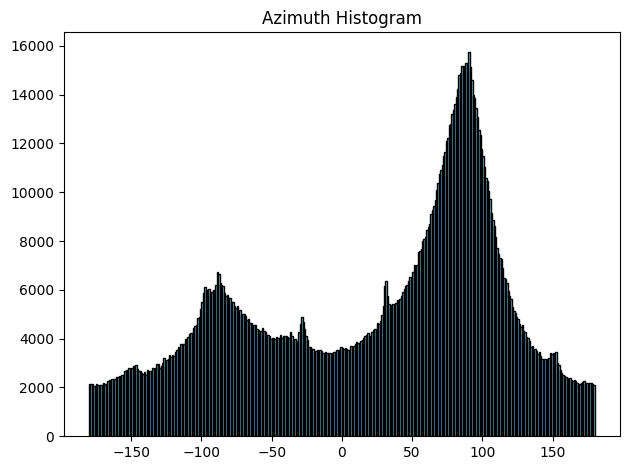

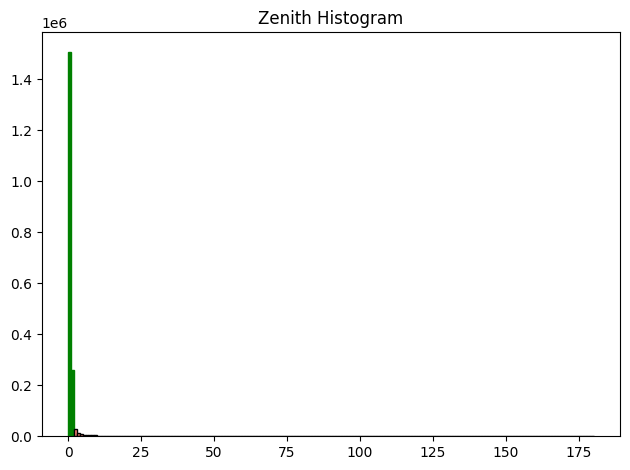

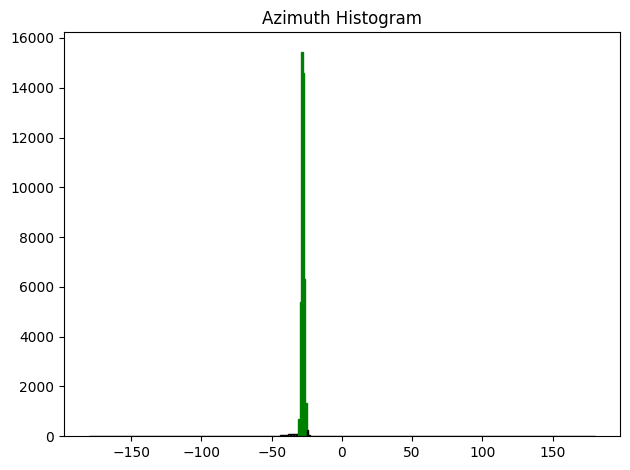

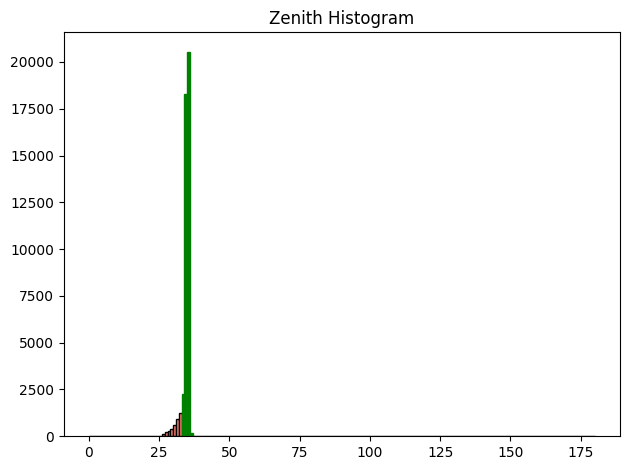

Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = True, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane 1 = False
Alignment: Plane 0 = False, Plane

In [14]:
visualizer = ArcLengthCalculator(pcd = pcd, intersection_line=intersection_line, bend_edges=bend_edges, bend_cluster_points=cluster_points, cluster_derivatives=cluster_derivatives, all_normals=all_normals, segment_indices=segment_indices)
visualizer.run()